## Target Obs Stratgey



> First, we need to import some packages in Julia

In [1]:
using Pkg
Pkg.activate("../.."); # Actives the environment at the root of the project
# Using our Carbon-I and vSmartMOM packages (developed by our team)
using CarbonI
using Dates, DelimitedFiles, XLSX, DataFrames

  Activating project at `~/code/gitHub/CarbonI`
┌ Info: CUDA-enabled GPU(s) detected
└ @ vSmartMOM /home/cfranken/code/gitHub/vSmartMOM.jl/src/vSmartMOM.jl:57
┌ Info: CUDA.CuDevice(0): NVIDIA A100-PCIE-40GB
└ @ vSmartMOM /home/cfranken/code/gitHub/vSmartMOM.jl/src/vSmartMOM.jl:59
┌ Info: CUDA.CuDevice(1): NVIDIA A100-PCIE-40GB
└ @ vSmartMOM /home/cfranken/code/gitHub/vSmartMOM.jl/src/vSmartMOM.jl:59


In [2]:
using  CairoMakie, Interpolations
include(joinpath("../../src/Plots", "CI_colorsNew.jl"))
# Read the Excel data
filename = "../../data/Plant.csv"

# The Load CARMA data
# The readtable function returns a tuple; we convert it to a DataFrame.
data = readdlm(filename,',', skipstart=1)
emi = data[:,4]
emi[emi.==""] .= NaN

emissions_annual = convert.(Float64,emi);

# Load CH4 from Airborne Campaigns (Cusworth PNAS paper)
filename = "../../data/carbonmapper_ch4_plumelist_2020_2021.xlsx"
sheetname = "carbonmapper_ch4_plumelist_2020"
# The readtable function returns a tuple; we convert it to a DataFrame.
data = DataFrame(XLSX.readtable(filename, sheetname))
plumes_ch4 = convert.(Float64,data[!,"qplume"]);

In [3]:
CarbonI_colors

In [4]:
# Process CARMA data
emissions_hourly_co2 = emissions_annual ./ 8760.0
# Clean NaNs
emissions_hourly_co2_clean = filter(!isnan, emissions_hourly_co2);
# Avoid duplicates later:
emissions_hourly_co2_clean .+= (randn(length(emissions_hourly_co2_clean))*eps(1e-10).+1e-9)
# 3. Sort the hourly emissions array in ascending order (for a CDF).
sorted_emissions = sort(emissions_hourly_co2_clean, rev=true);
sorted_emissions_rev = sort(emissions_hourly_co2_clean, rev=false);

# 4. Compute the cumulative sum and normalize by the total. This gives an
#    empirical cumulative distribution function (CDF) of total emissions.
cdf_vals = cumsum(sorted_emissions) ./ sum(sorted_emissions);
cdf_vals_rev = cumsum(sorted_emissions_rev) ./ sum(sorted_emissions_rev);

inter_cdf = LinearInterpolation( 100cdf_vals, sorted_emissions);
inter_cdf_rev = LinearInterpolation(  sorted_emissions_rev[sorted_emissions_rev.>0],100cdf_vals_rev[sorted_emissions_rev.>0]);

┌ Warning: Duplicated knots were deduplicated. Use Interpolations.deduplicate_knots!(knots) explicitly to avoid this warning.
│   k1 = [1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 1.0e-9, 

In [5]:
# Process CH4:

# 3. Sort the hourly emissions array in ascending order (for a CDF).
sorted_emissions_ch4 = sort(plumes_ch4, rev=true);
sorted_emissions_rev_ch4 = sort(plumes_ch4, rev=false);

# 4. Compute the cumulative sum and normalize by the total. This gives an
#    empirical cumulative distribution function (CDF) of total emissions.
cdf_vals_ch4 = cumsum(sorted_emissions_ch4) ./ sum(sorted_emissions_ch4);
cdf_vals_rev_ch4 = cumsum(sorted_emissions_rev_ch4) ./ sum(sorted_emissions_rev_ch4);

inter_cdf_ch4 = LinearInterpolation( 100cdf_vals_ch4, sorted_emissions_ch4);
inter_cdf_rev_ch4 = LinearInterpolation(  sorted_emissions_rev_ch4[sorted_emissions_rev_ch4.>0],100cdf_vals_rev_ch4[sorted_emissions_rev_ch4.>0]);

In [6]:
# Specify requirements for CO2
req_global = 100
req_target = 35

cbe_global = 50
cbe_target = 18

# What fraction of plumes we want to detect:
req_percent = 85.0

85.0

In [7]:
# Specify requirements for CH4
req_global_ch4 = 175
req_target_ch4 = 62

cbe_global_ch4 = 84.5
cbe_target_ch4 = 31

# What fraction of plumes we want to detect:
req_percent_ch4 = 90.0

90.0

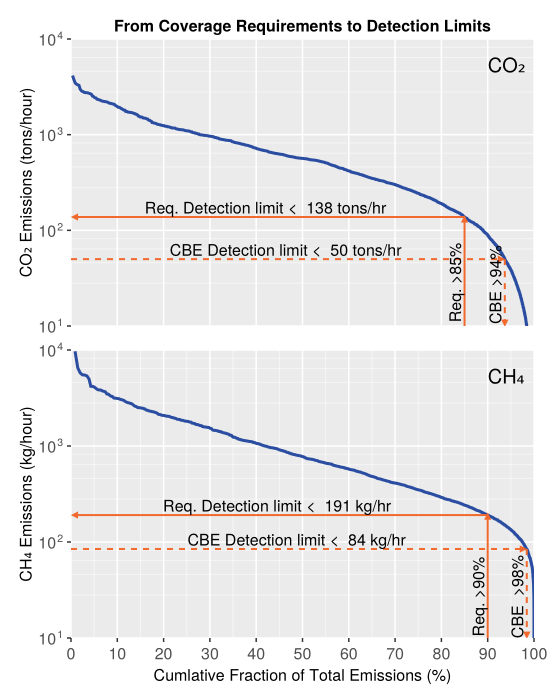

In [8]:

set_theme!(theme_ggplot2())
# 5. Create a Figure and an Axis for the plot using CairoMakie.
fig = Figure(resolution=(550,700))
ax = Axis(fig[1,1];
    ylabel = "CO₂ Emissions (tons/hour)",
    
    title = "From Coverage Requirements to Detection Limits",
    yscale = log10,
    xticks = 0:10:100,
    yminorgridvisible=true,
    #xminorgridvisible=true,
    #xminorticks = IntervalsBetween(5),
    yminorticks = IntervalsBetween(5)
    )

req_flux = inter_cdf(req_percent)
cbe_percent = 100 .- inter_cdf_rev(cbe_global)
@show cbe_percent
# 6. Plot the data as a line. Use `lines!` or `steppre!`/`steppost!` for a classic stepwise ECDF.
lines!(ax,  100cdf_vals,sorted_emissions,color = CarbonI_colors[4], linewidth=3)
#lines!(ax,  [req_percent,req_percent],[10,inter_cdf(req_percent)], color = :red)
arrows!(ax, [req_percent,],[10,],[0,],[req_flux-20,],arrowsize = 10, linewidth=2,color = CarbonI_colors[5])
arrows!(ax, [req_percent,],[req_flux,],[-req_percent+1,],[0,],arrowsize = 10, linewidth=2,color = CarbonI_colors[5])


#@show inter_cdf(req_percent)
text!(ax, "Req. Detection limit <  $(round(Int, req_flux)) tons/hr ", position = (req_percent/2,req_flux),
      align = (:center, :bottom), color = :black)

arrows!(ax, [0,],[cbe_global,],[cbe_percent-1,],[0,],arrowsize = 10, linewidth=2,color = CarbonI_colors[5], linestyle = :dash)
arrows!(ax, [cbe_percent,],[cbe_global,],[0,],[-cbe_global+11,],arrowsize = 10, linewidth=2,color = CarbonI_colors[5],linestyle = :dash)

      
#@show inter_cdf(req_percent)
text!(ax, "CBE Detection limit <  $(round(Int, cbe_global)) tons/hr ", position = (cbe_percent/2,cbe_global),
            align = (:center, :bottom), color = :black)
text!(ax, " Req. >85%", position = (req_percent, 27),
            align = (:center, :bottom), color = :black, rotation=π/2)
text!(ax, "CBE >$(round(Int, cbe_percent))%", position = (cbe_percent, 27),
    align = (:center, :bottom), color = :black, rotation=π/2)
#text!(ax, "50th Percentile", position = (arrow_x, arrow_tip_y + 10),
   #   align = (:center, :bottom), color = :red)
ylims!(ax, 10, 10000)
xlims!(ax, 0, 100)
hidexdecorations!(ax, grid=false)

ax2 = Axis(fig[2,1];
    ylabel = "CH₄ Emissions (kg/hour)",
    xlabel = "Cumlative Fraction of Total Emissions (%)",
    #title = "Empirical CDF of Hourly CO₂ Emissions",
    yscale = log10,
    xticks = 0:10:100,
    yminorgridvisible=true,
    #xminorgridvisible=true,
    #xminorticks = IntervalsBetween(5),
    yminorticks = IntervalsBetween(5)
    )

req_flux_ch4 = inter_cdf_ch4(req_percent_ch4)
cbe_percent_ch4 = 100 .- inter_cdf_rev_ch4(cbe_global_ch4)
@show cbe_percent
# 6. Plot the data as a line. Use `lines!` or `steppre!`/`steppost!` for a classic stepwise ECDF.
lines!(ax2,  100cdf_vals_ch4,sorted_emissions_ch4,color = CarbonI_colors[4], linewidth=3)
#lines!(ax,  [req_percent,req_percent],[10,inter_cdf(req_percent)], color = :red)
arrows!(ax2, [req_percent_ch4,],[10,],[0,],[req_flux_ch4-20,],arrowsize = 10, linewidth=2,color = CarbonI_colors[5])
arrows!(ax2, [req_percent_ch4,],[req_flux_ch4,],[-req_percent_ch4+1,],[0,],arrowsize = 10, linewidth=2,color = CarbonI_colors[5])
text!(ax2, "Req. >90%", position = (req_percent_ch4, 27),
      align = (:center, :bottom), color = :black, rotation=π/2)

#@show inter_cdf(req_percent)
text!(ax2, "Req. Detection limit <  $(round(Int, req_flux_ch4)) kg/hr ", position = (req_percent_ch4/2,req_flux_ch4),
      align = (:center, :bottom), color = :black)

arrows!(ax2, [0,],[cbe_global_ch4,],[cbe_percent_ch4-1,],[0,],arrowsize = 10, linewidth=2,color = CarbonI_colors[5], linestyle = :dash)
arrows!(ax2, [cbe_percent_ch4,],[cbe_global_ch4,],[0,],[-cbe_global_ch4+11,],arrowsize = 10, linewidth=2,color = CarbonI_colors[5],linestyle = :dash)
text!(ax2, "CBE  >$(round(Int, cbe_percent_ch4))%", position = (cbe_percent_ch4, 27),
    align = (:center, :bottom), color = :black, rotation=π/2)
      
#@show inter_cdf(req_percent)
text!(ax2, "CBE Detection limit <  $(round(Int, cbe_global_ch4)) kg/hr ", position = (cbe_percent_ch4/2,cbe_global_ch4),
            align = (:center, :bottom), color = :black)
text!(ax2, "CH₄", position = (90, 4e3),
            align = (:left, :bottom), color = :black, fontsize=20)
text!(ax, "CO₂", position = (90, 4e3),
            align = (:left, :bottom), color = :black, fontsize=20)
#text!(ax, "50th Percentile", position = (arrow_x, arrow_tip_y + 10),
   #   align = (:center, :bottom), color = :red)
ylims!(ax2, 10, 10000)
xlims!(ax2, 0, 100)
save("../../plots/final/CO2_CH4_Flux_Detection.pdf", fig)
save("../../plots/final/SectionD-D9-CO2_CH4_Flux_Detection.eps", fig)
fig     

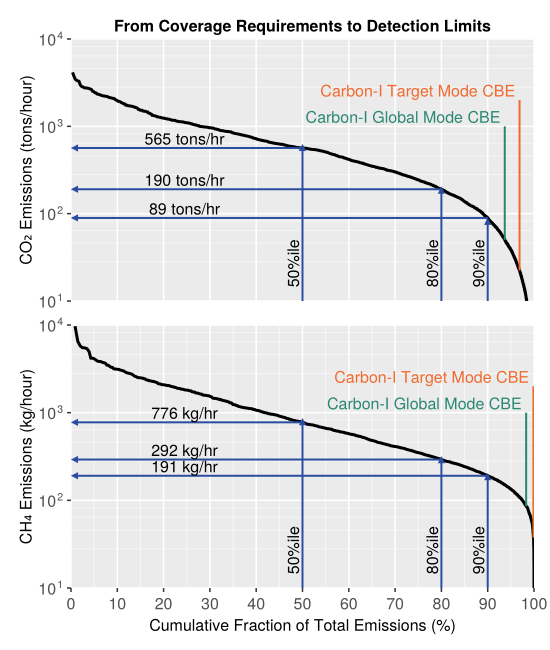

In [9]:
req_percents = [50, 80, 90]
set_theme!(theme_ggplot2())
# 5. Create a Figure and an Axis for the plot using CairoMakie.
fig = Figure(resolution=(550,650))
ax = Axis(fig[1,1];
    ylabel = "CO₂ Emissions (tons/hour)",
    
    title = "From Coverage Requirements to Detection Limits",
    yscale = log10,
    xticks = 0:10:100,
    yminorgridvisible=true,
    #xminorgridvisible=true,
    #xminorticks = IntervalsBetween(5),
    yminorticks = IntervalsBetween(5)
    )
    lines!(ax,  100cdf_vals,sorted_emissions,color = :black, linewidth=3)
for req_percent in req_percents
    req_flux = inter_cdf(req_percent)
    arrows!(ax, [req_percent,],[10,],[0,],[req_flux-20,],arrowsize = 10, linewidth=2,color = CarbonI_colors[4])
    arrows!(ax, [req_percent,],[req_flux,],[-req_percent+1,],[0,],arrowsize = 10, linewidth=2,color = CarbonI_colors[4])
    text!(ax, "$(round(Int, req_flux)) tons/hr ", position = (25,req_flux),
      align = (:center, :bottom), color = :black)
      text!(ax, "$(round(Int, req_percent))%ile", position = (req_percent, 27),
      align = (:center, :bottom), color = :black, rotation=π/2)
end
# Plot CBE GLobal and Target
cbe_target_co2 = 2.24e+04/1e3; cbe_percent_target = 100 .- inter_cdf_rev(cbe_target_co2)
cbe_global_co2 = 5.01e+04/1e3; cbe_percent_global = 100 .- inter_cdf_rev(cbe_global_co2)
lines!(ax, [cbe_percent_target,cbe_percent_target],[cbe_target_co2,2000],linewidth=2,color = CarbonI_colors[5])
text!(ax, "Carbon-I Target Mode CBE ", position = (cbe_percent_target,2000),
      align = (:right, :bottom), color = CarbonI_colors[5])
lines!(ax, [cbe_percent_global,cbe_percent_global],[cbe_global_co2,1000],linewidth=2,color = CarbonI_colors[3])
text!(ax, "Carbon-I Global Mode CBE ", position = (cbe_percent_global,1000),
      align = (:right, :bottom), color = CarbonI_colors[3])

ylims!(ax, 10, 10000)
xlims!(ax, 0, 100)
hidexdecorations!(ax, grid=false)

ax2 = Axis(fig[2,1];
    ylabel = "CH₄ Emissions (kg/hour)",
    xlabel = "Cumulative Fraction of Total Emissions (%)",
    #title = "Empirical CDF of Hourly CO₂ Emissions",
    yscale = log10,
    xticks = 0:10:100,
    yminorgridvisible=true,
    #xminorgridvisible=true,
    #xminorticks = IntervalsBetween(5),
    yminorticks = IntervalsBetween(5)
    )

req_flux_ch4 = inter_cdf_ch4(req_percent_ch4)
cbe_percent_ch4 = 100 .- inter_cdf_rev_ch4(cbe_global_ch4)
@show cbe_percent
# 6. Plot the data as a line. Use `lines!` or `steppre!`/`steppost!` for a classic stepwise ECDF.
lines!(ax2,  100cdf_vals_ch4,sorted_emissions_ch4,color = :black, linewidth=3)
for req_percent in req_percents
    req_flux = inter_cdf_ch4(req_percent)
    arrows!(ax2, [req_percent,],[10,],[0,],[req_flux-20,],arrowsize = 10, linewidth=2,color = CarbonI_colors[4])
    arrows!(ax2, [req_percent,],[req_flux,],[-req_percent+1,],[0,],arrowsize = 10, linewidth=2,color = CarbonI_colors[4])
    text!(ax2, "$(round(Int, req_flux)) kg/hr ", position = (25,req_flux),
      align = (:center, :bottom), color = :black)
      text!(ax2, "$(round(Int, req_percent))%ile", position = (req_percent, 27),
      align = (:center, :bottom), color = :black, rotation=π/2)
end
# Plot CBE GLobal and Target
cbe_target_ch4 = 37.5; cbe_percent_target = 100 .- inter_cdf_rev_ch4(cbe_target_ch4)
cbe_global_ch4 = 85.5; cbe_percent_global = 100 .- inter_cdf_rev_ch4(cbe_global_ch4)
lines!(ax2, [cbe_percent_target,cbe_percent_target],[cbe_target_ch4,2000],linewidth=2,color = CarbonI_colors[5])
text!(ax2, "Carbon-I Target Mode CBE ", position = (cbe_percent_target,2000),
      align = (:right, :bottom), color = CarbonI_colors[5])
lines!(ax2, [cbe_percent_global,cbe_percent_global],[cbe_global_ch4,1000],linewidth=2,color = CarbonI_colors[3])
text!(ax2, "Carbon-I Global Mode CBE ", position = (cbe_percent_global,1000),
      align = (:right, :bottom), color = CarbonI_colors[3])

ylims!(ax2, 10, 10000)
xlims!(ax2, 0, 100)
save("../../plots/final/CO2_CH4_Flux_Detection.pdf", fig)
save("../../plots/final/SectionD-D9-CO2_CH4_Flux_Detection.eps", fig)
fig     